In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import Precision, Recall, F1Score
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Embedding
import seaborn as sns

chuẩn bị dữ liệu

In [ ]:
# tham số index_col chỉ định cột sử dụng làm chỉ mục cho bảng
df = pd.read_csv('Phishing_Email.csv', index_col = [0])

In [ ]:
df.head()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18650 entries, 0 to 18650
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email Text  18634 non-null  object
 1   Email Type  18650 non-null  object
dtypes: object(2)
memory usage: 437.1+ KB


In [ ]:
# hàm isna() tạo ra 1 dataframe kích thước giống bảng ban đầu nhưng chỉ chứa các
# giá trị True (giá trị NaN) hoặc False (không phải NaN)
print(df.isna().sum())

Email Text    16
Email Type     0
dtype: int64


In [ ]:
# kiểm tra xem có hàng nào bị trùng lặp hay không
print(df.duplicated().sum())

1111


In [ ]:
# loại bỏ các hàng có giá trị NaN
df.dropna(inplace=True)

# loại bỏ các hàng có giá trị trùng lặp
df.drop_duplicates(inplace=True)

Text(0.5, 1.0, 'Number of Phishing email and Safe email messages')

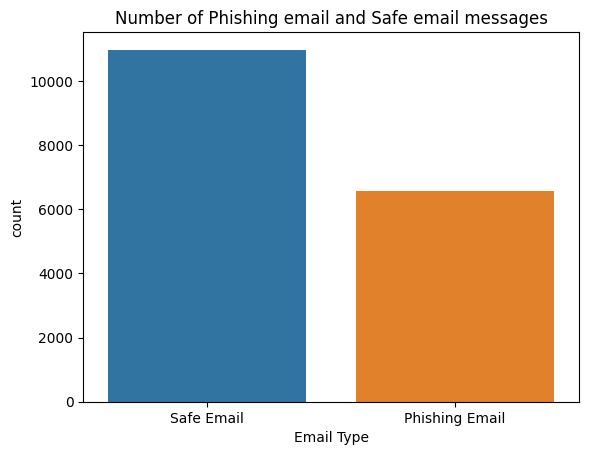

In [ ]:
sns.countplot(data=df, x='Email Type')
plt.xlabel('Email Type')
plt.title('Number of Phishing email and Safe email messages')

In [ ]:
x = df['Email Text']
y = df['Email Type']

In [ ]:
le = LabelEncoder()

# y = 1 nếu safe email
# y = 0 nếu phising email
y = le.fit_transform(y)

# biến y từ mảng 1D thành vector cột 2D
y = y.reshape(-1, 1)

In [ ]:
y.shape

(17538, 1)

In [ ]:
# chia dataset thành train/val/test set với tỉ lệ 0.6/0.2/0.2
x_train, x_untrained, y_train, y_untrained = train_test_split(x, y, test_size = 0.4, random_state = 10)
x_val, x_test, y_val, y_test = train_test_split(x_untrained, y_untrained, test_size = 0.5, random_state = 10)

In [ ]:
max_words = 10000
max_len = 150
tok = Tokenizer(num_words = max_words)

# fit_on_texts: tạo ra 1 từ vựng từ training_set với kích thước max_words
# texts_to_sequences: chuyển đổi mỗi từ trong câu thành 1 số nguyên dựa trên từ vựng
# pad_sequences: cắt bớt hoặc chèn thêm 0 vào mỗi vector từ để được kích thước max_len
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences, maxlen = max_len)

val_sequences = tok.texts_to_sequences(x_val)
val_sequences_matrix = pad_sequences(val_sequences, maxlen = max_len)

test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen = max_len)

In [ ]:
print(sequences[0])

[676, 415, 3772, 332, 48, 764, 22, 2409, 207, 207, 207, 207, 207, 13, 61, 9, 420, 165, 3178, 462, 16, 27, 682, 146, 83, 2, 15, 678, 22, 39, 1583, 72, 13, 620, 81, 66, 9, 842, 27, 960, 770, 2, 1584, 1368, 35, 960, 30, 620, 476, 235, 72, 476, 187, 439, 81, 692, 187, 439, 81, 187, 231, 476]


In [ ]:
sequences_matrix

array([[   0,    0,    0, ...,  187,  231,  476],
       [   0,    0,    0, ...,   35,   30,  185],
       [   0,    0,    0, ...,  231,  334, 2592],
       ...,
       [   0,    0,    0, ...,  575, 1335, 2044],
       [   0,    0,    0, ...,   66, 7648,   81],
       [   0,    0,    0, ..., 2042,   35,   30]], dtype=int32)

In [ ]:
sequences_matrix.shape, val_sequences_matrix.shape, test_sequences_matrix.shape

((10522, 150), (3508, 150), (3508, 150))

xây dựng mô hình

In [ ]:
model = Sequential()

# Embedding(input_dim, output_dim)
# input_dim: kích thước của từ vựng
# output_dim: kích thước vector embedding
model.add(Embedding(10000, 32))

# LSTM(unit, activation)
# unit: số chiều của vector đầu ra
# activation: hàm kích hoạt
model.add(LSTM(32, activation = 'sigmoid'))

# Dense(unit, activation)
# unit: kích thước vector đầu ra
# activation: hàm kích hoạt
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 328353 (1.25 MB)
Trainable params: 328353 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer = Adam(learning_rate = 1e-3)

In [ ]:
# sử dụng binary_cross_entropy_loss
# hàm tối ưu Adam
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy', Precision(), Recall()])

huấn luyện mô hình

In [ ]:
history = model.fit(sequences_matrix, y_train, epochs=15, batch_size=128, validation_data = (val_sequences_matrix, y_val))

Epoch 1/15
83/83 [==============================] - 47s 429ms/step - loss: 0.6470 - accuracy: 0.6220 - precision: 0.6220 - recall: 1.0000 - val_loss: 0.5925 - val_accuracy: 0.6465 - val_precision: 0.6448 - val_recall: 1.0000
Epoch 2/15
83/83 [==============================] - 33s 400ms/step - loss: 0.4716 - accuracy: 0.7847 - precision: 0.7552 - recall: 0.9676 - val_loss: 0.3115 - val_accuracy: 0.8900 - val_precision: 0.9331 - val_recall: 0.8925
Epoch 3/15
83/83 [==============================] - 31s 371ms/step - loss: 0.1665 - accuracy: 0.9483 - precision: 0.9600 - recall: 0.9568 - val_loss: 0.1414 - val_accuracy: 0.9524 - val_precision: 0.9550 - val_recall: 0.9716
Epoch 4/15
83/83 [==============================] - 30s 359ms/step - loss: 0.0927 - accuracy: 0.9732 - precision: 0.9841 - recall: 0.9727 - val_loss: 0.1225 - val_accuracy: 0.9587 - val_precision: 0.9799 - val_recall: 0.9551
Epoch 5/15
83/83 [==============================] - 29s 345ms/step - loss: 0.0602 - accuracy: 0.9854

In [ ]:
# mặc định batch_size của evaluate là 32
results = model.evaluate(test_sequences_matrix, y_test)
loss = results[0]
accuracy = results[1]

print(f"Model Loss: {loss}")
print(f"Model Accuracy: {accuracy*100}")

110/110 [==============================] - 3s 27ms/step - loss: 0.1357 - accuracy: 0.9618 - precision: 0.9767 - recall: 0.9615
Model Loss: 0.13571755588054657
Model Accuracy: 96.18015885353088


Text(0, 0.5, 'Loss')

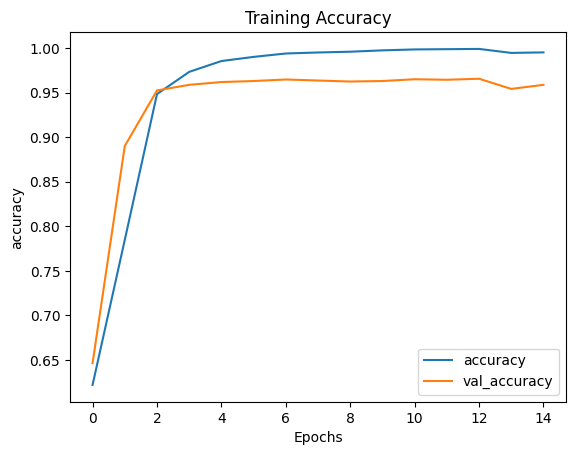

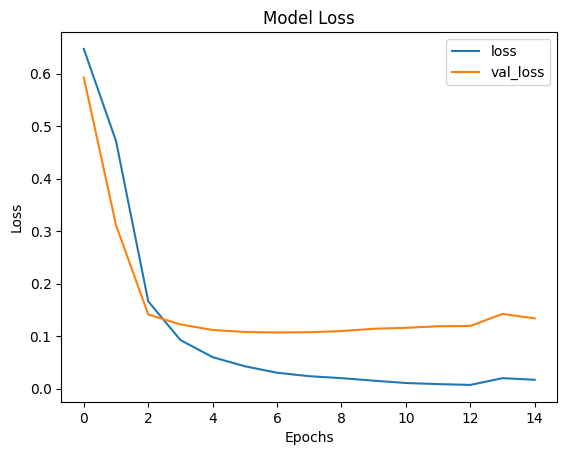

In [ ]:
pd.DataFrame(history.history)

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
y_pred_prob = model.predict(test_sequences_matrix)
y_pred = (y_pred_prob > 0.5).astype(int)

110/110 [==============================] - 2s 20ms/step


In [ ]:
report = classification_report(y_true = y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1324
           1       0.98      0.96      0.97      2184

    accuracy                           0.96      3508
   macro avg       0.96      0.96      0.96      3508
weighted avg       0.96      0.96      0.96      3508

